## Rician noise and least squares analysis demonstration--April 25, 2023
## Generates signals and recovers parameters from noisy data, with either Gaussian or Rician noise.  Can select monoexponential or biexponential analysis
## This and all other user inputs are in the cell immediately after the import cell
#### Things yet to do: 1) sort out normalization and 2) implement the stacked form to get regularized solutions
#### Anyone--what's a better way to flag the whole thing as for monoexponential versus biexp analysis?

#### Import packages

In [164]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import iv
import scipy as scipy
from scipy import optimize
from scipy import special
import functools

#### Choose mono- or bi-exp model; define SNR and time points.
#### This is the only cell that needs to be touched, to define the various parameters

In [165]:
Model = 2 # choose 1 or 2 for monoexp or biexp
if Model==1:
    c=1.8; T2=45
if Model==2:
    c1=.4; c2=.8; T21=30; T22=100
    true_params = [c1, c2, T21, T22]
tvect=np.linspace(0,500,101)
SNR=100

# Monoexponential signal

In [166]:
def MonoExpAmp(tvect, c, T2):
    Signal = c*np.exp(-tvect/T2)
    return Signal

## Biexponential signal

In [167]:
def BiExpAmp(tvect, c1, c2, T21, T22):
    Signal = c1*np.exp(-tvect/T21)+c2*np.exp(-tvect/T22)
    return Signal

# Define model and calculate sigma from SNR

In [168]:
# noiseless signal
if Model==1:
    SigVect=MonoExpAmp(tvect, c, T2)
if Model==2:    
    SigVect=BiExpAmp(tvect, c1, c2, T21, T22)
sigma=np.max(SigVect)/SNR
print(sigma)

0.012000000000000002


# Add Gaussian noise to the signal
## Plot the noisy signal

In [169]:
noise=np.random.normal(loc=0.0, scale=sigma, size=len(tvect))
SigVect_noisy=SigVect+noise

Text(0, 0.5, 'signal amplitude')

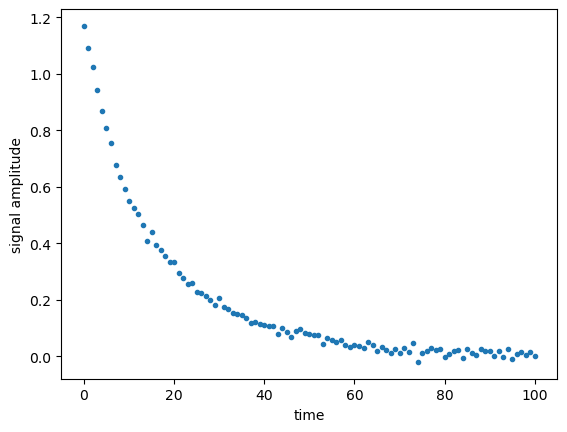

In [170]:
plt.plot(SigVect_noisy,"o", markersize=3)
plt.xlabel("time")
plt.ylabel("signal amplitude")

# Fit the noisy data to the model

In [171]:
if Model==1:
    popt_fit, pcov_fit = scipy.optimize.curve_fit(MonoExpAmp, tvect, SigVect_noisy, p0=[1,40])
if Model==2:
    popt_fit, pcov_fit = scipy.optimize.curve_fit(BiExpAmp, tvect, SigVect_noisy, p0=[1,1,30,40])
popt_fit

array([  0.41889691,   0.76758044,  33.09359216, 103.14157823])

In [172]:
if Model==1:
    print(c,T2,SNR)
if Model==2:
    print(c1,c2,T21,T22, SNR)

0.4 0.8 30 100 100


Text(0, 0.5, 'Amplitudes')

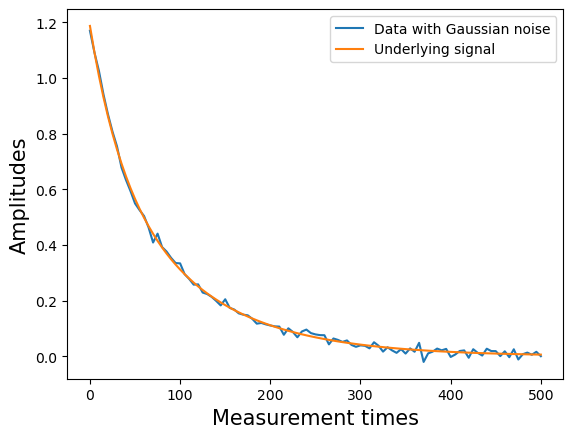

In [173]:
if Model==1:
    plt.plot(tvect,SigVect_noisy,tvect,MonoExpAmp(tvect,popt_fit[0],popt_fit[1]))
    plt.legend(['Data with Gaussian noise','Underlying signal'])
if Model==2:
    plt.plot(tvect,SigVect_noisy,tvect,BiExpAmp(tvect,popt_fit[0],popt_fit[1],popt_fit[2],popt_fit[3]))
    plt.legend(['Data with Gaussian noise','Underlying signal'])
plt.xlabel("Measurement times", fontsize=15)
plt.ylabel('Amplitudes',fontsize=15)    

# Same thing, but now with Rician noise
# Add Rician noise to the signal
## Plot the noisy signal

In [174]:
noise_floor=np.sqrt(np.pi/2)*sigma
noise_real=np.random.normal(loc=0.0, scale=sigma, size=len(tvect))
noise_imag=np.random.normal(loc=0.0, scale=sigma, size=len(tvect))

In [175]:
noisy_sig_channel=SigVect+noise_real
noisy_quadrature_channel=noise_imag
SigVect_noisy=np.sqrt(noisy_sig_channel**2+noisy_quadrature_channel**2)

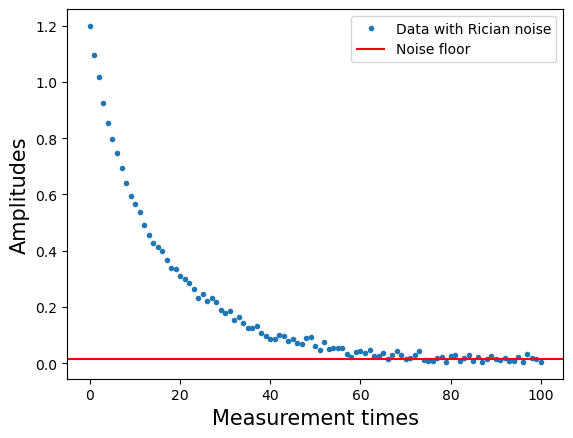

In [176]:
plt.plot(SigVect_noisy,"o", markersize=3)
plt.axhline(y = noise_floor, color = 'r', linestyle = '-')
plt.xlabel("time")
plt.ylabel("signal amplitude")
plt.xlabel("Measurement times", fontsize=15)
plt.ylabel('Amplitudes',fontsize=15)
plt.legend(['Data with Rician noise','Noise floor'])

# Now fit the noisy signal to the Rician model

## Define the signal corrupted by Rician noise

In [177]:
if Model==1:
    def expectation_Rice(tvect,c,T2):
        alpha=(MonoExpAmp(tvect, c, T2)/(2*sigma))**2        
        Expectation = sigma*np.sqrt(np.pi/2)*((1+2*alpha)*special.ive(0, alpha) + 2*alpha*special.ive(1,alpha))
        return Expectation
# plt.plot(expectation_Rice(tvect,c,T2,sigma))
# plt.plot(expectation_Rice(tvect,c1,c2,T21,T22,sigma))
    plt.plot(expectation_Rice(tvect,c,T2))
    plt.axhline(y = noise_floor, color = 'r', linestyle = '-')
    plt.xlabel("Measurement times", fontsize=15)
    plt.ylabel('Amplitudes',fontsize=15)
    plt.legend(['Expectation value of signal with Rician noise','Noise floor'])

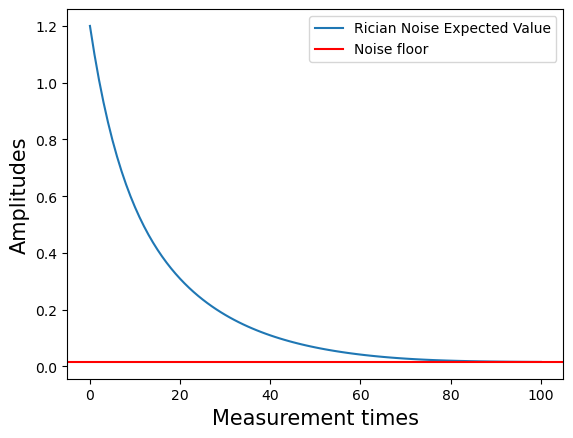

In [178]:
# def expectation_Rice(tvect,c,T2):
# special.ive(0, x) = np.exp(-x)*iv(0,x)
if Model==2:
    def expectation_Rice(tvect,c1,c2,T21,T22):
        alpha=(BiExpAmp(tvect, c1, c2, T21, T22)/(2*sigma))**2
        Expectation = sigma*np.sqrt(np.pi/2)*((1+2*alpha)*special.ive(0, alpha) + 2*alpha*special.ive(1,alpha)) 
        #note that np.exp(-alpha) is tied into the special.ive function
        return Expectation


# plt.plot(expectation_Rice(tvect,c,T2,sigma))
# plt.plot(expectation_Rice(tvect,c1,c2,T21,T22,sigma))
    plt.plot(expectation_Rice(tvect,c1,c2,T21,T22))
    plt.axhline(y = noise_floor, color = 'r', linestyle = '-')
    plt.xlabel("Measurement times", fontsize=15)
    plt.ylabel('Amplitudes',fontsize=15)
    plt.legend(['Rician Noise Expected Value','Noise floor'])

## Do the least-squares fit to the signal with Rician noise

In [179]:
if Model==1:
    popt_fit, pcov_fit = scipy.optimize.curve_fit(expectation_Rice, tvect, SigVect_noisy, p0=[c,T2])
if Model==2:
    popt_fit, pcov_fit = scipy.optimize.curve_fit(expectation_Rice, tvect, SigVect_noisy, p0=[0.4,0.8,30,100])

popt_fit

array([ 0.31813332,  0.88319579, 25.29383807, 93.96794173])

In [180]:
if Model==1:
    print(c,T2,SNR)
if Model==2:
    print(c1,c2,T21,T22, SNR) #true underlying values

0.4 0.8 30 100 100


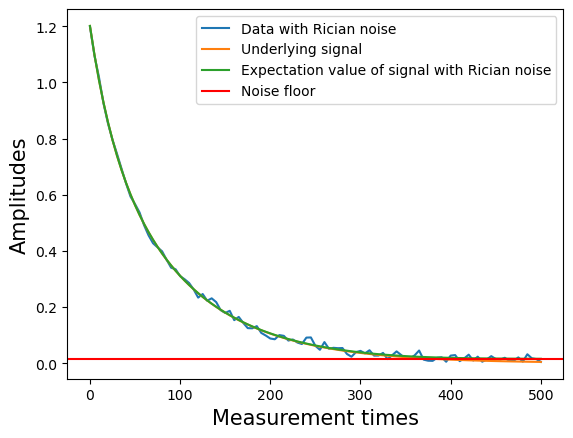

In [181]:
if Model==1:
    plt.plot(tvect,SigVect_noisy,\
            tvect,popt_fit[0]*np.exp(-tvect/popt_fit[1]),\
            tvect, expectation_Rice(tvect,c,T2))
if Model==2:
    plt.plot(tvect, SigVect_noisy,\
            tvect, BiExpAmp(tvect, *popt_fit),\
            tvect, expectation_Rice(tvect, *popt_fit))
plt.axhline(y = noise_floor, color = 'r', linestyle = '-')
plt.xlabel("Measurement times", fontsize=15)
plt.ylabel('Amplitudes',fontsize=15)
plt.legend(['Data with Rician noise','Underlying signal', 'Expectation value of signal with Rician noise','Noise floor'])

In [186]:
data_noise_floor = np.mean(SigVect_noisy[-5:])
data_sigma = data_noise_floor* (2/np.pi)**(1/2)
data_SNR = SigVect_noisy[0]/data_sigma
print(f"Experimentally we see SNR = {data_SNR}")

Experimentally we see SNR = 103.09277514059683


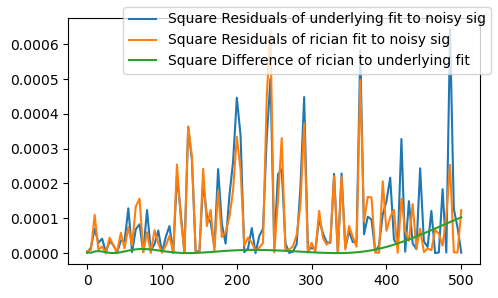

In [183]:
fig, ax = plt.subplots(1,1,figsize=(5,3),tight_layout=True)
ax.plot(tvect,(SigVect_noisy - BiExpAmp(tvect, *true_params))**2, label = 'Square Residuals of underlying fit to noisy sig')
ax.plot(tvect,(SigVect_noisy - expectation_Rice(tvect, *popt_fit))**2, label = 'Square Residuals of rician fit to noisy sig')
ax.plot(tvect,(BiExpAmp(tvect, *true_params) - expectation_Rice(tvect, *popt_fit))**2, label = 'Square Difference of rician to underlying fit')
fig.legend()
